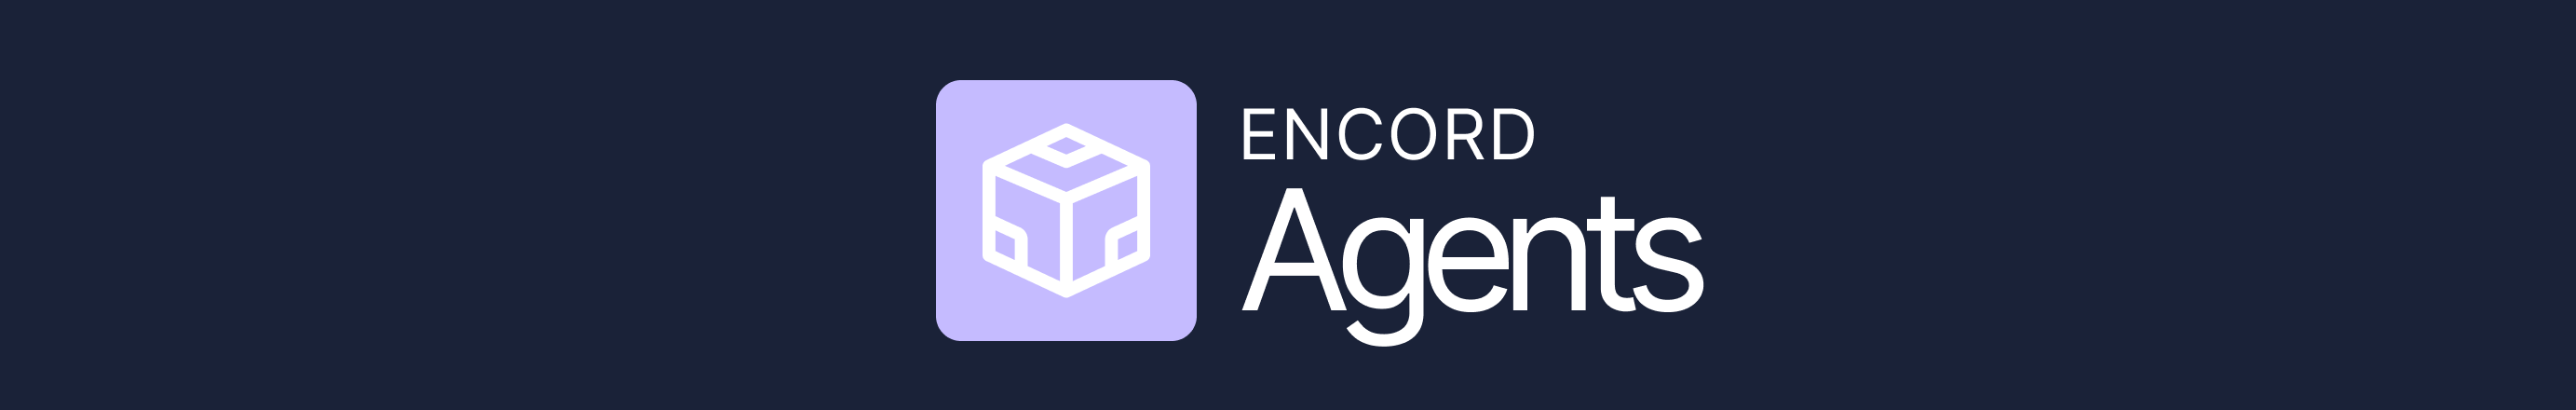

## The Goal of This Notebook

This notebook uses a Large Language Model (LLM) to evaluate and select the better product image description from two different LLM-generated descriptions.  

The LLM judge assesses the correctness and quality of each description, provides improvement suggestions, and determines which option is more accurate. Additionally, this notebook covers generating descriptions using Visual Language Models (VLMs), uploading captions as files, and including them in groupings within Encord.  

Once the LLM judge is set up, it can be repurposed by adjusting the ontology in the Encord project to align with different evaluation criteria.


## Set Up Encord Project

This notebook is intended for a setup containing two types of files:

1. Images that are the subject matter.
2. Text (`.txt`) files that contain LLM descriptions of the images.

Data is linked together with [custom client metadata](https://docs.encord.com/sdk-documentation/datasets-sdk/sdk-client-metadata#import-custom-metadata-datasets).
Client metadata allows you to:

1. [Configure your editor layout](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-project-settings#custom-editor-layout) to display multiple data units at the same time. In this example, the image and the two responses are displayed together using custom metadata.

2. Read and filter custom metadata to refine queries for the LLM judge.

In this example, we use two custom metadata entries:

```python
Tag: UUID,
Data Type: Literal['Image', 'Text_8B', 'Text_16B']
```

- The `Tag` is used for "grouping" items, such that we know which image each response belongs to.
- The `Data Type` tells what the data is and where it came from.

### The Dataset(s)

This notebook assumes that the images have been uploaded to Encord and that the Datasets are attached to your Project.


### Project Workflow

Ensure your Project has the following Workflow.


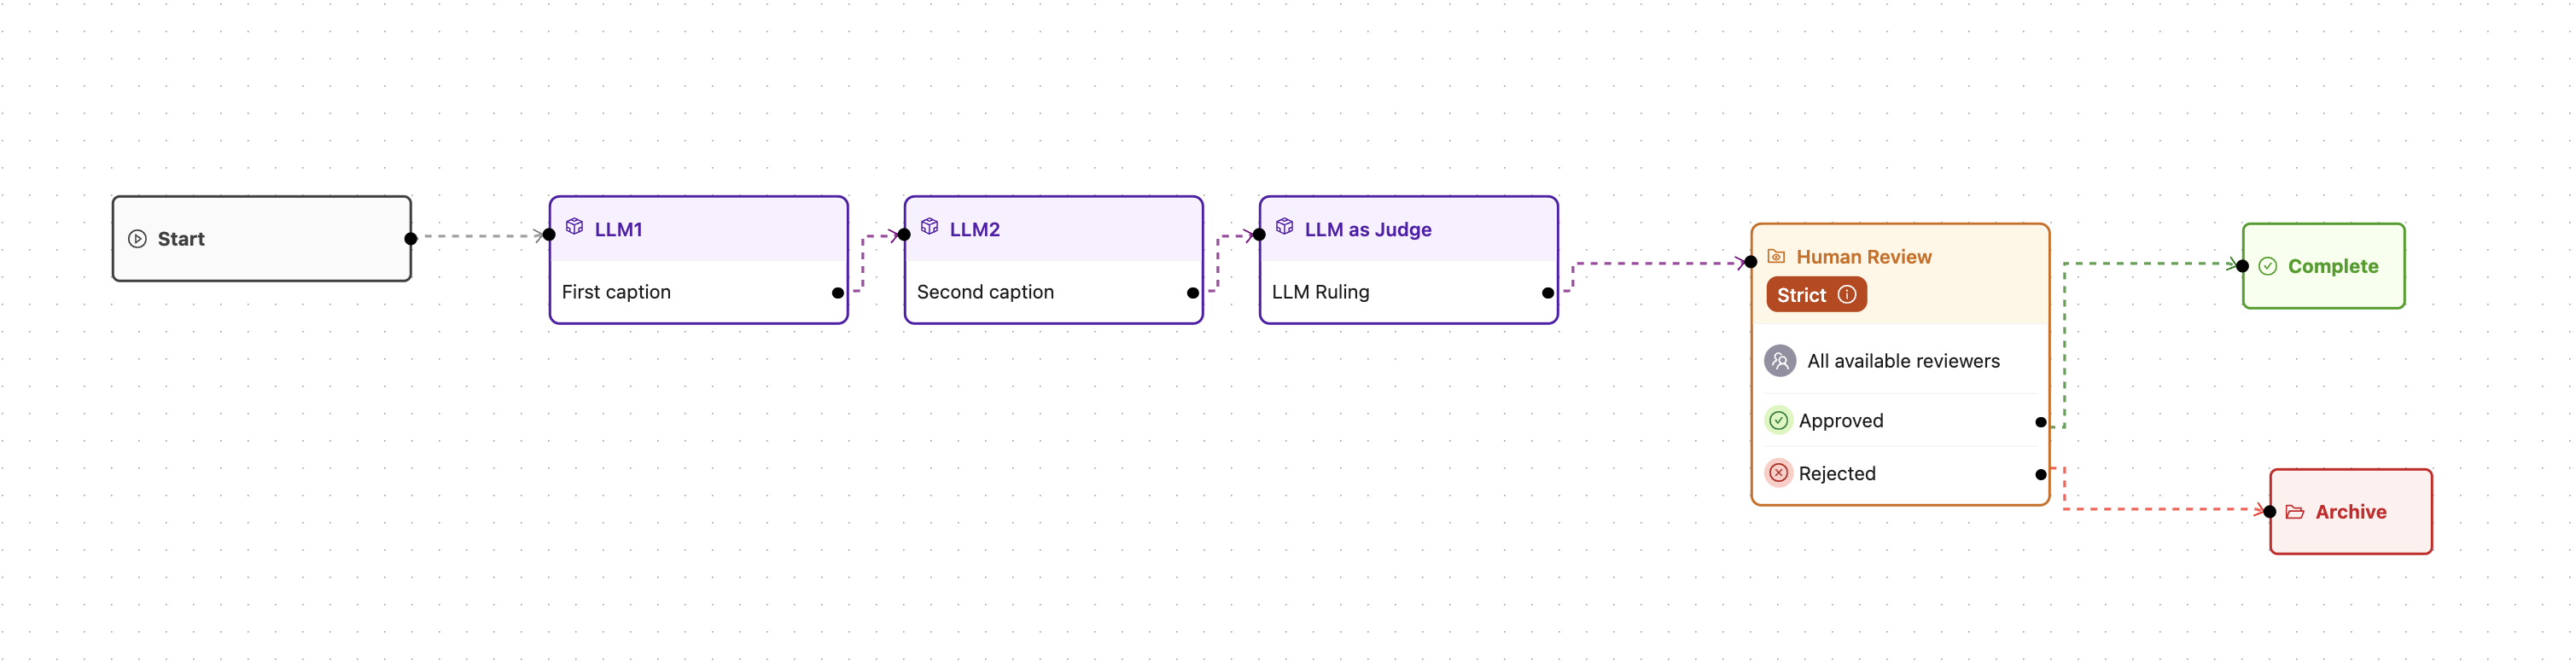

We demonstrate how to implement the ""LLM1" "LLM2" and "LLM as a Judge" agents node in this notebook.

1. LLM1 produces the first set of captions for the image.
2. LLM2 produces the second set of captions for the image.
3. The LLM as a Judge stage compares the captions and selects the superior option.

### The Ontology

Ensure you Project has the following Ontology:

> ⚠️ **The screenshot below is shortened for convenience. Ensure that LLM 16B has the exact same classification options and answers as those seen for LLM 8B**

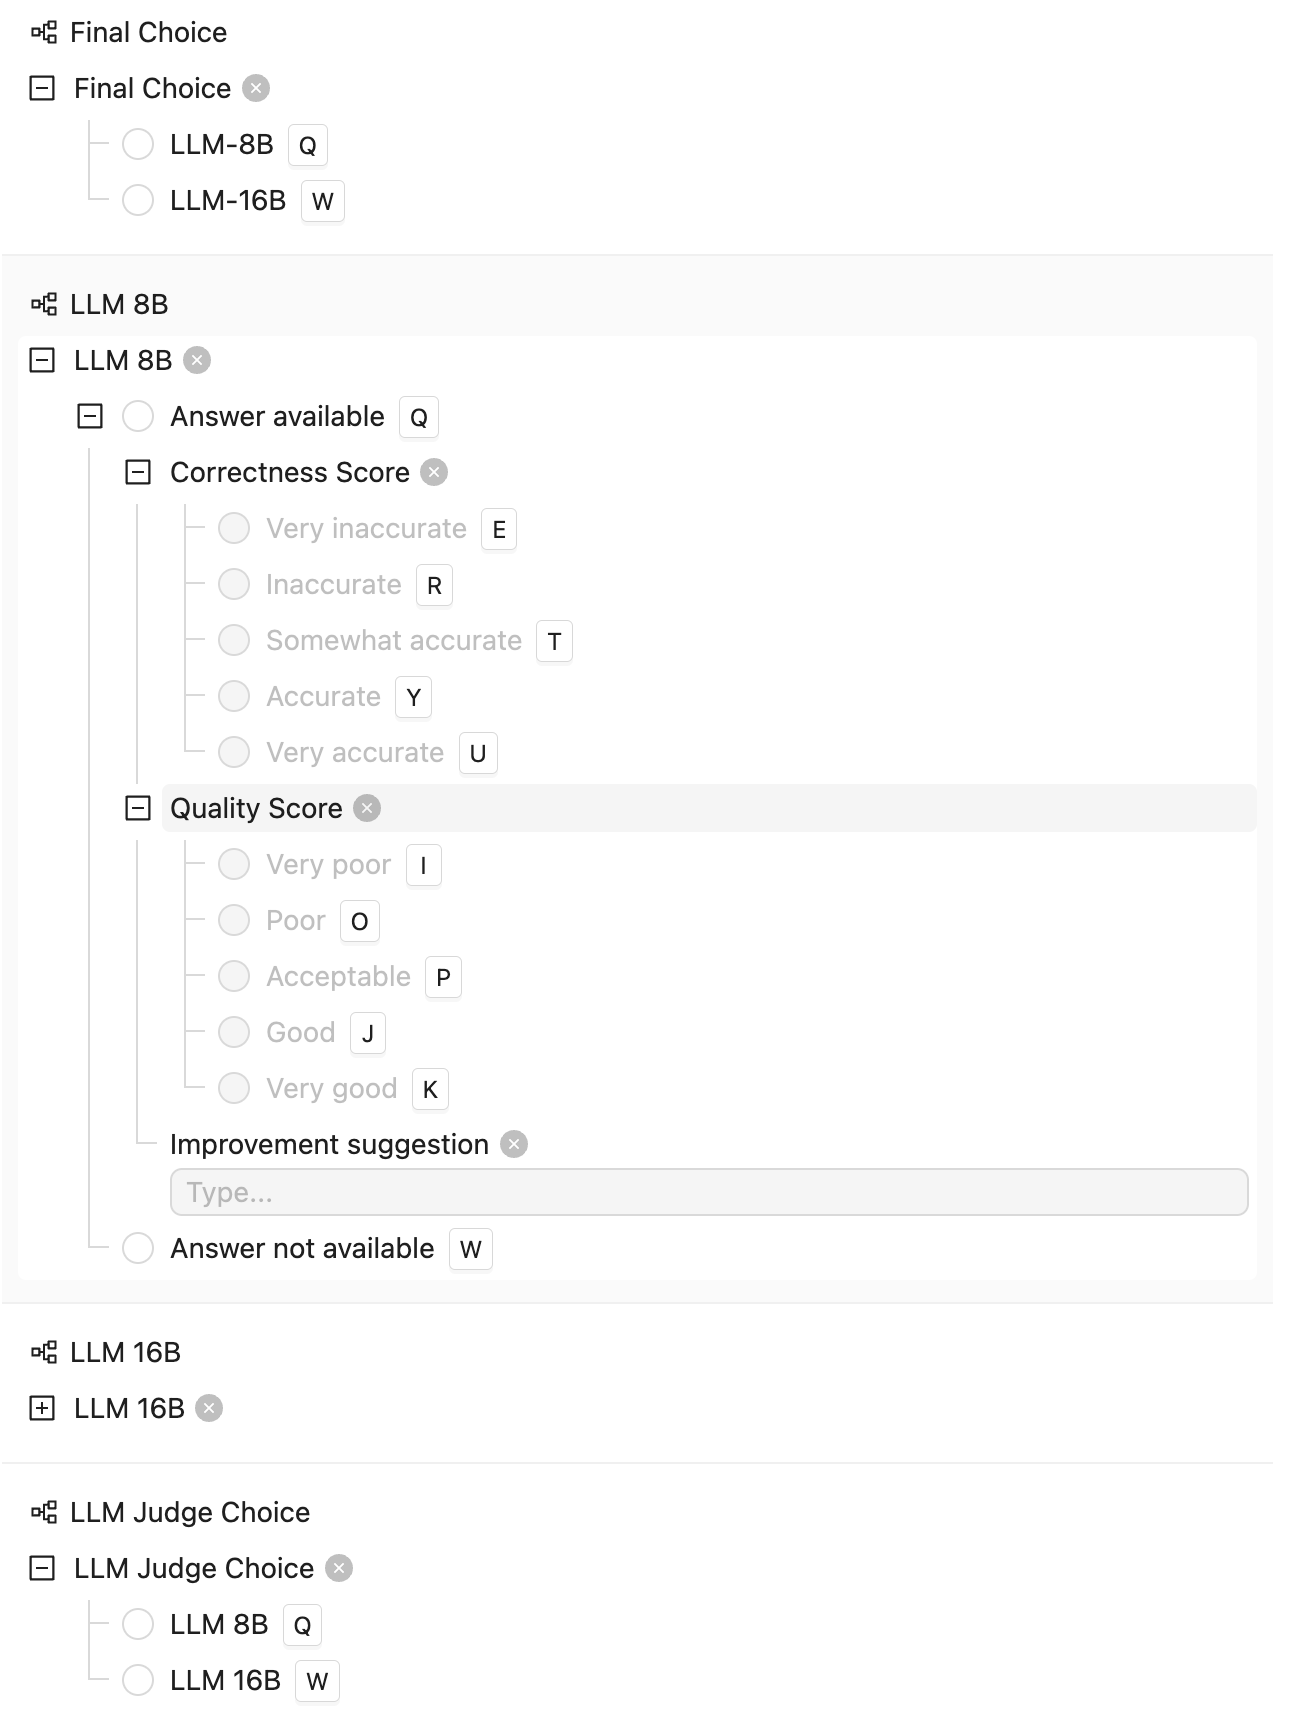


The first entry, **"Final Choice,"** is reserved for a human to make the final judgment in the Encord platform.  

All remaining entries in the Ontology are filled in by the LLM.


### Label Editor Layout

To ensure your Project's default Label Editor layout matches the layout seen beloiw, you must upload a custom layout `json` file to the Project in the Project Settings.



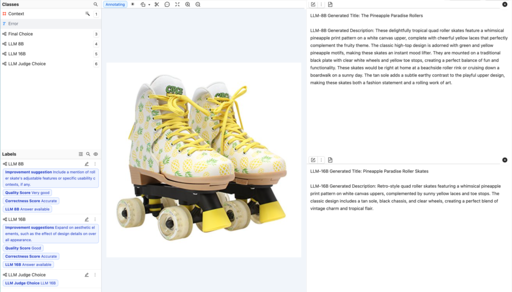


A schema for the JSON file is defined below. Run the code cell to generate the `editor_layout.json` file, which appears in the file drawer on the left.

Download the file and follow the instructions [here](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-project-settings#custom-editor-layout) to add the layout to your Project.

In [ ]:
%%file editor_layout.json
{
  "name": "tri_layout",
  "grid": {
    "direction": "row",
    "first": 0,
    "second": {
      "direction": "column",
      "first": 1,
      "second": 2,
      "splitPercentage": 50
    },
    "splitPercentage": 50
  },
  "gridContent": {
    "0": {
      "readonly": false,
      "dicomTagsQuery": null,
      "clientMetadataQuery": {
        "andConditions": [
          {
            "key": "Data Type",
            "operator": "=",
            "value": "Image"
          },
          {
            "key": "Data Type",
            "operator": "=",
            "value": "Image"
          }
        ]
      }
    },
    "1": {
      "readonly": false,
      "dicomTagsQuery": null,
      "clientMetadataQuery": {
        "andConditions": [
          {
            "key": "Data Type",
            "operator": "=",
            "value": "Text_8B"
          },
          {
            "key": "Data Type",
            "operator": "=",
            "value": "Text_8B"
          }
        ]
      }
    },
    "2": {
      "readonly": false,
      "dicomTagsQuery": null,
      "clientMetadataQuery": {
        "andConditions": [
          {
            "key": "Data Type",
            "operator": "=",
            "value": "Text_16B"
          },
          {
            "key": "Data Type",
            "operator": "=",
            "value": "Text_16B"
          }
        ]
      }
    }
  },
  "topLevelGridFilter": {
    "dicomTags": null,
    "clientMetadata": {
      "key": "Tag",
      "operator": "="
    }
  },
  "settings": {
    "fixedLayout": false
  }
}

## Set Up Agents

The following example combines Encord's multi-modal capabilities with its Editor layout feature. It evaluates LLM-generated image descriptions by using a VLM to determine which description is the most accurate.

### Installation

Ensure that you install:
- The `encord-agents` library.
- The `openai` library.

In [ ]:
!pip install encord-agents openai

### Authentication

The library authenticates via ssh-keys. Below, is a code cell for setting the `ENCORD_SSH_KEY` and `OPENAI_API_KEY`environment variables. It should contain the raw content of your private ssh key file and OpenAI API key.

If you have not yet setup an ssh key, please follow the [documentation](https://agents-docs.encord.com/authentication/).

> 💡 **Colab users**: In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks with
> ```python
> import os
> from google.colab import userdata
> os.environ["ENCORD_SSH_KEY"] = userdata.get("ENCORD_SSH_KEY")
> os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
> ```

### Imports

In [ ]:
# Imports
from contextlib import contextmanager
from pathlib import Path
from typing import Generator, Literal

from encord.constants.enums import DataType
from encord.http.bundle import Bundle
from encord.objects.classification import Classification
from encord.objects.classification_instance import ClassificationInstance
from encord.objects.ontology_labels_impl import LabelRowV2
from openai import OpenAI
from pydantic import ValidationError

from encord_agents.core.data_model import Frame, LabelRowMetadataIncludeArgs
from encord_agents.core.ontology import OntologyDataModel
from encord_agents.tasks import Runner
from encord_agents.tasks.dependencies import dep_asset

### Set Up Runner and Define Functions

Initialize the OpenAI client and set up your runner.

> ⚠️ Ensure that you replace `<project_hash>` with the unique ID of your Encord Project.

In [ ]:
PROJECT_HASH = "<your-project-hash>"  # @param {type: "string"}

In [ ]:
# Create OpenAI client
openai_client = OpenAI()

In [ ]:
runner = Runner(project_hash=PROJECT_HASH)

# Choose classifications to label with LLM judge
# Everything with "LLM" in the name will be judged by the LLM.
classifications = runner.project.ontology_structure.classifications
for i, clf in enumerate(classifications):
    print(
        f"{clf.title[:25]:25s} [{clf.attributes[0].get_property_type():^7s}] {'' if 'LLM' in clf.title else 'not '}selected"
    )

# Exclude human choices ()
llm_classifications = [clf for clf in runner.project.ontology_structure.classifications if "LLM" in clf.title]
ont_data_model: OntologyDataModel[Classification] = OntologyDataModel(llm_classifications)

### Associating Data Items  

When querying two LLMs for descriptions of the same item, a mechanism is needed to associate the descriptions for comparison, synthesis, and display in the Editor layout. This association is handled using client metadata.  

To optimize performance, a cached version of these pairings is calculated using the following approach:  

In [ ]:
from collections import defaultdict

# Build a loop up to be able to find text files from image label rows.
# Key: the "Tag"
# Value: the LabelRow for the item
label_row_groups: dict[str, dict[Literal["Text_8B", "Text_16B"], LabelRowV2]] = defaultdict(dict)

In [ ]:
from typing import Annotated

from encord import EncordUserClient
from encord.dataset import Dataset
from encord.orm.dataset import DataLinkDuplicatesBehavior
from encord.project import Project
from encord.storage import StorageItem

from encord_agents.tasks import Depends
from encord_agents.tasks.dependencies import dep_client, dep_single_frame, dep_storage_item


def dep_dataset(user_client: Annotated[EncordUserClient, Depends(dep_client)], project: Project) -> Dataset:
    """
    Dependency to get first dataset associated to project
    Used to have a dataset reference for linking items from storage
    """
    project_dataset = next(iter(project.list_datasets()))
    dataset = user_client.get_dataset(project_dataset.dataset_hash)
    return dataset

### Code Outline  

The two captioning LLMs are defined sequentially, following a similar process with one key difference. The first example generates a tag, while the second retrieves the tag from the image and applies it to ensure consistency across both descriptions.

In [ ]:
runner = Runner(project_hash=PROJECT_HASH)

In [ ]:
def call_openai_captioning(frame: Frame) -> str:
    prompt = """Please provide a caption of the following image. Don't respond with anything else and just immediately proceed into the caption.
  Keep it within 20 words"""

    # Call openai
    response = openai_client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "user",
                "content": [{"type": "text", "text": prompt}, frame.b64_encoding(output_format="openai")],
            }
        ],
    )
    model_response = response.choices[0].message.content or "Failed to get resp"
    return model_response

## LLM1 Agent

The LLM1 Agent creates the first set of captions for the image.

In [ ]:
import tempfile
from typing import Annotated
from uuid import uuid4


@runner.stage(
    stage="LLM1",
    label_row_metadata_include_args=LabelRowMetadataIncludeArgs(include_client_metadata=True),
)
def first_llm_captioning(
    lr: LabelRowV2,
    storage_item: Annotated[StorageItem, Depends(dep_storage_item)],
    project: Project,
    dataset: Annotated[Dataset, Depends(dep_dataset)],
) -> str:
    if not lr.data_type == DataType.IMAGE:
        # Only do it for images.
        return "First caption"
    frame = Frame(frame=0, content=dep_single_frame(lr))
    caption = call_openai_captioning(frame)
    print(f"First LLM caption for {lr.data_title[:12]}: {caption}")
    storage_folder = storage_item.parent_folder()
    # Generate tag to identify this image's captions from
    tag = str(uuid4())
    # Update the metadata for this to include the tag
    storage_item.update(client_metadata={"Tag": tag, "Data Type": "Image"})

    with tempfile.NamedTemporaryFile(suffix=".txt") as tmp:
        tmp.write(caption.encode())
        tmp.seek(0)
        uploaded_txt_uuid = storage_folder.upload_text(
            file_path=tmp.name,
            title=f"LLM1Captionfor{lr.data_hash}-{lr.data_title}.txt",
            client_metadata={"Data Type": "Text_8B", "Tag": tag},
        )
    # Link the newly created item to our project and cache it as associated with the image locally
    data_rows = dataset.link_items([uploaded_txt_uuid], DataLinkDuplicatesBehavior.DUPLICATE)
    data_row = data_rows[0]
    lr = project.list_label_rows_v2(data_hashes=[data_row.uid])[0]
    label_row_groups[tag]["Text_8B"] = lr
    return "First caption"

## LLM2 Agent

The LLM2 Agent creates the second set of captions for the image. Only notable change is how we are tagging the label row

In [ ]:
@runner.stage(
    stage="LLM2",
    label_row_metadata_include_args=LabelRowMetadataIncludeArgs(include_client_metadata=True),
)
def second_llm_captioning(
    lr: LabelRowV2,
    storage_item: Annotated[StorageItem, Depends(dep_storage_item)],
    project: Project,
    dataset: Annotated[Dataset, Depends(dep_dataset)],
) -> str:
    if not lr.data_type == DataType.IMAGE:
        # Only do it for images.
        return "Second caption"
    frame = Frame(frame=0, content=dep_single_frame(lr))
    caption = call_openai_captioning(frame)
    print(f"Second LLM caption for {lr.data_title[:12]}: {caption}")
    storage_folder = storage_item.parent_folder()
    tag = storage_item.client_metadata["Tag"]

    with tempfile.NamedTemporaryFile(suffix=".txt") as tmp:
        tmp.write(caption.encode())
        tmp.seek(0)
        uploaded_txt_uuid = storage_folder.upload_text(
            file_path=tmp.name,
            title=f"LLM2Captionfor{lr.data_hash}-{lr.data_title}.txt",
            client_metadata={"Data Type": "Text_16B", "Tag": tag},
        )
    dataset.link_items([uploaded_txt_uuid])
    data_rows = dataset.link_items([uploaded_txt_uuid], DataLinkDuplicatesBehavior.DUPLICATE)
    data_row = data_rows[0]
    lr = project.list_label_rows_v2(data_hashes=[data_row.uid])[0]
    label_row_groups[tag]["Text_16B"] = lr
    return "Second caption"

## LLM as a Judge

At this stage, responses from LLM 1 and LLM 2 are carefully evaluated to ensure they meet the required format and better option based on criteria outlined in the Ontology is selected.

Unlike the previous stage, where responses could be uploaded directly, this step involves validation to maintain accuracy and consistency. OpenAI's JSON schema support is used to validate responses before they are processed further.

In [ ]:
def call_openai_for_comparison(frame: Frame, choice_1: str, choice_2: str) -> list[ClassificationInstance]:
    prompt = f"""You are a helpful Image description judge choosing the better option
based on multiple criteria defined in a JSON schema.
    Please judge the two choices in relation to the provided image.

    Please choose from the following two descriptions of the image which best summarises the Image.
    Please follow the JSON Schema to indicate your response.
    Don't respond with anything but valid json.

    === JSON Schema ===
    {ont_data_model.model_json_schema_str}

    === Choice 1: LLM 8B ===
    {choice_1}

    === Choice 2: LLM 16B ===
    {choice_2}

    """
    # Call openai
    response = openai_client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "user",
                "content": [{"type": "text", "text": prompt}, frame.b64_encoding(output_format="openai")],
            }
        ],
        response_format={"type": "json_object"},
    )
    data_model_response = response.choices[0].message.content or "Failed to get resp"

    # Parse response with ontology data model to get classification instances
    try:
        instances = ont_data_model(data_model_response)
    except ValidationError as e:
        # invalid json
        print("Failed to get appropriate JSON Schema resp")
        print(f"{data_model_response=}")
        print(f"{ont_data_model.model_json_schema_str=}")
        raise e
    return instances

In [ ]:
# Context manager used to fetch contents of files with LLM descriptions
@contextmanager
def fetch_asset_lr(lr: LabelRowV2) -> Generator[Path, None, None]:
    with contextmanager(dep_asset)(lr) as asset:
        yield asset


def dep_llm_answers(lr: LabelRowV2) -> tuple[str, str] | None:
    """
    Custom dependency to read in the descriptions from the text files
    """
    if not lr.data_type == DataType.IMAGE:
        # Only do it for images.
        return None

    # Find relevant entries via the look up
    lr_tag = lr.client_metadata["Tag"]
    group_dict = label_row_groups[lr_tag]
    lr_8B = group_dict["Text_8B"]
    lr_16B = group_dict["Text_16B"]

    # Initialize labels to get signed urls
    with Bundle() as bundle:
        if not lr_8B.is_labelling_initialised:
            lr_8B.initialise_labels(include_signed_url=True, bundle=bundle)
        if not lr_16B.is_labelling_initialised:
            lr_16B.initialise_labels(include_signed_url=True, bundle=bundle)

    # Load the content from the text files
    with fetch_asset_lr(lr_8B) as path_asset_8B:
        asset_8B = path_asset_8B.read_text()
    with fetch_asset_lr(lr_16B) as path_asset_16B:
        asset_16B = path_asset_16B.read_text()

    return asset_8B, asset_16B

In [ ]:
def choose_better_answer(lr: LabelRowV2, frame: Frame, choice_1: str, choice_2: str) -> None:
    """Choose the better answer from the two options and write it onto the LabelRow"""
    classification_instances = call_openai_for_comparison(frame, choice_1, choice_2)

    # Store the answers in the label row
    for inst in classification_instances:
        inst.set_for_frames()
        lr.add_classification_instance(inst)


@runner.stage(
    stage="LLM as Judge",
    label_row_metadata_include_args=LabelRowMetadataIncludeArgs(include_client_metadata=True),
)
def judge_labels(
    lr: LabelRowV2,
    responses: Annotated[tuple[str, str] | None, Depends(dep_llm_answers)],
) -> str | None:
    if not responses:
        # This means that we're looking at a text file.
        # Just send it directly to complete as we'll be looking at them via the images.
        lr.workflow_complete()
        return None

    frame = Frame(frame=0, content=dep_single_frame(lr))
    response_8B, response_16B = responses
    choose_better_answer(lr, frame, response_8B, response_16B)

    lr.save()
    return "LLM Ruling"

Execute runner

In [ ]:
runner()

## Outcome

If you've followed the steps above, you now have a workflow that leverages multiple VLM captioning methods and an additional model to select the best caption. This approach is particularly useful for training or fine-tuning a captioning model.